# **LAB 10** #

**Necessary Packages**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

## **Load the Data** ##

In [12]:
# Load the Dogs vs Cats dataset (assumed to be stored in a directory named 'data')
train_dir = 'C:/Users/raj/machine_learning/NAGARAJU366/data/kaggle_dogs_vs_cats_small/train'
test_dir = 'C:/Users/raj/machine_learning/NAGARAJU366/data/kaggle_dogs_vs_cats_small/test'

# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## **EDA** ##

Training Data Class Counts:
{'cat': 1000, 'dog': 1000}

Testing Data Class Counts:
{'cat': 1000, 'dog': 1000}

Sample Training Images:


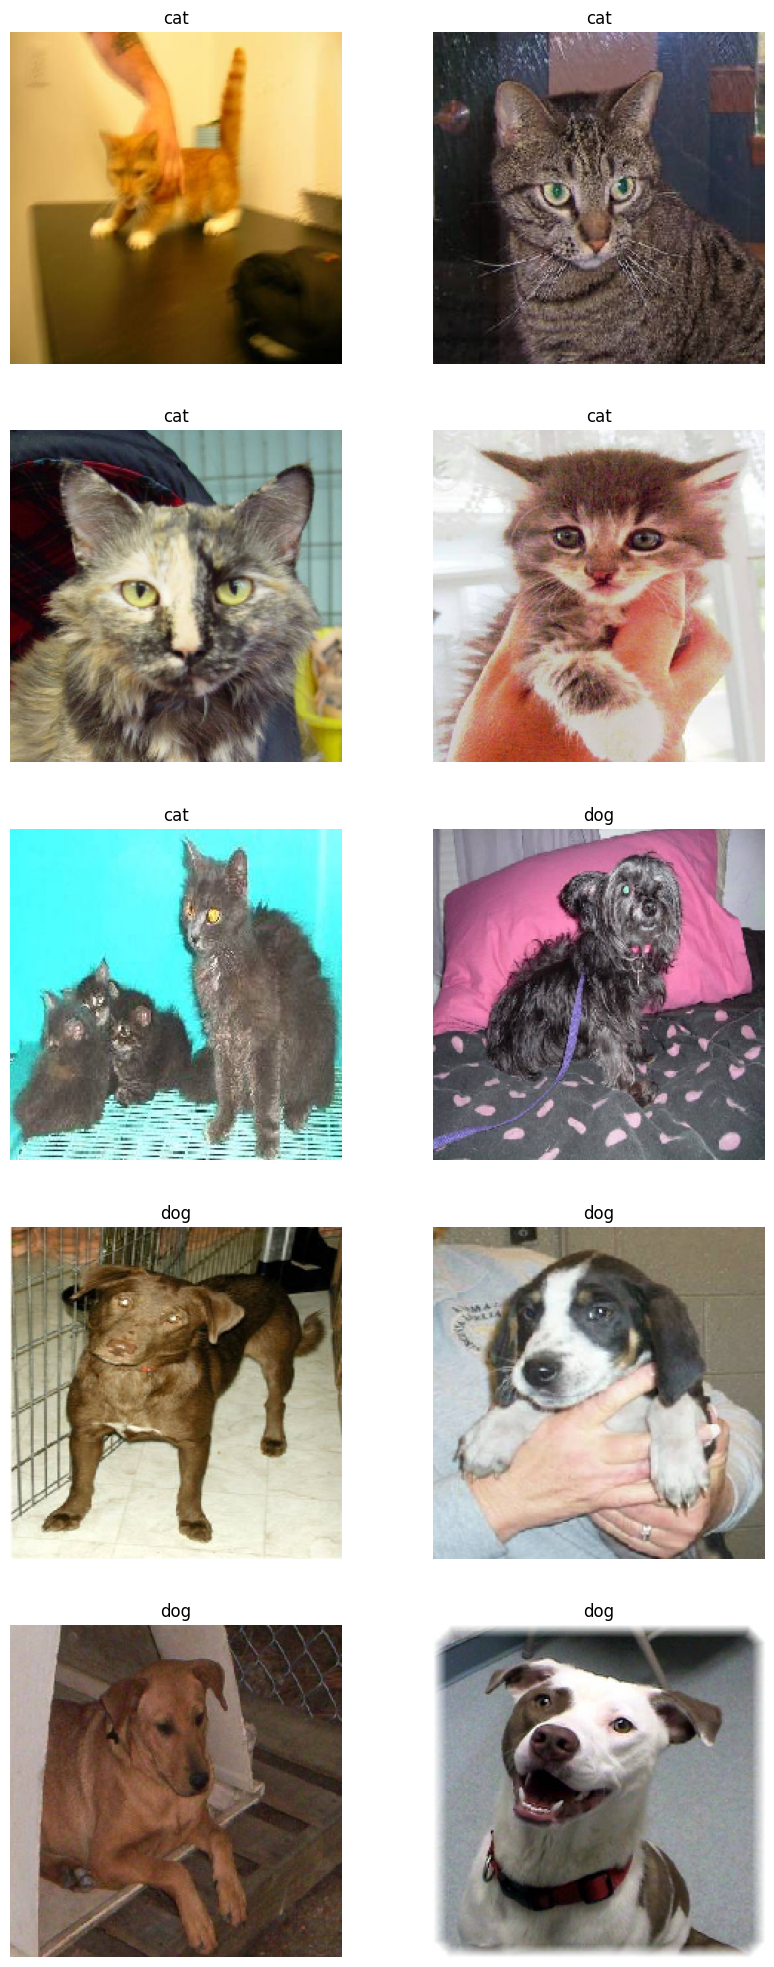


Sample Testing Images:


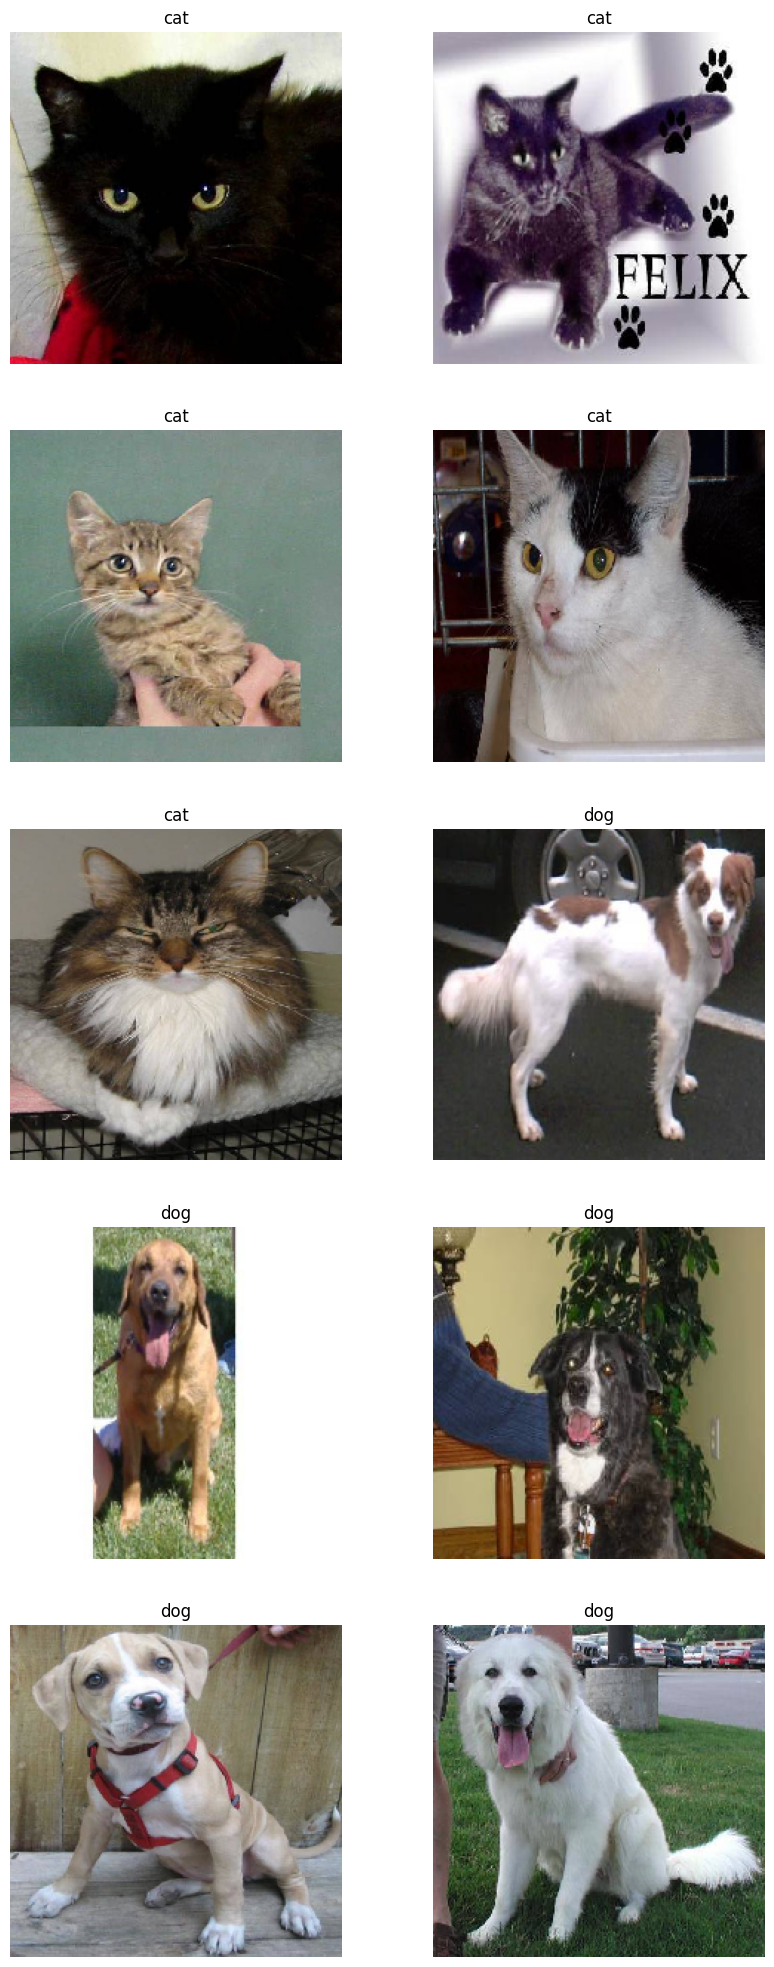

In [15]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Get list of class names
class_names = sorted(os.listdir(train_dir))

# Data Distribution
train_class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}
test_class_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in class_names}

print("Training Data Class Counts:")
print(train_class_counts)
print("\nTesting Data Class Counts:")
print(test_class_counts)

# Data Visualization
def plot_sample_images(directory, class_names, num_samples=5):
    plt.figure(figsize=(10, 5*num_samples))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        sample_images = os.listdir(class_dir)[:num_samples]
        for j, image_name in enumerate(sample_images):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(224, 224))
            plt.subplot(num_samples, len(class_names), i * num_samples + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis("off")
    plt.show()

print("\nSample Training Images:")
plot_sample_images(train_dir, class_names)

print("\nSample Testing Images:")
plot_sample_images(test_dir, class_names)


### **Modeling and Evaluation** ##

Epoch 1/10
63/63 [==============================] - 169s 3s/step - loss: 0.7094 - accuracy: 0.5045 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 166s 3s/step - loss: 0.6905 - accuracy: 0.5170 - val_loss: 0.6912 - val_accuracy: 0.5340
Epoch 3/10
63/63 [==============================] - 167s 3s/step - loss: 0.6861 - accuracy: 0.5425 - val_loss: 0.6600 - val_accuracy: 0.6335
Epoch 4/10
63/63 [==============================] - 162s 3s/step - loss: 0.6581 - accuracy: 0.6110 - val_loss: 0.6760 - val_accuracy: 0.5580
Epoch 5/10
63/63 [==============================] - 157s 2s/step - loss: 0.6379 - accuracy: 0.6435 - val_loss: 0.6425 - val_accuracy: 0.6625
Epoch 6/10
63/63 [==============================] - 155s 2s/step - loss: 0.5961 - accuracy: 0.6725 - val_loss: 0.6120 - val_accuracy: 0.6670
Epoch 7/10
63/63 [==============================] - 155s 2s/step - loss: 0.5332 - accuracy: 0.7280 - val_loss: 0.6241 - val_accuracy: 0.6565
Epoch 8/10
63

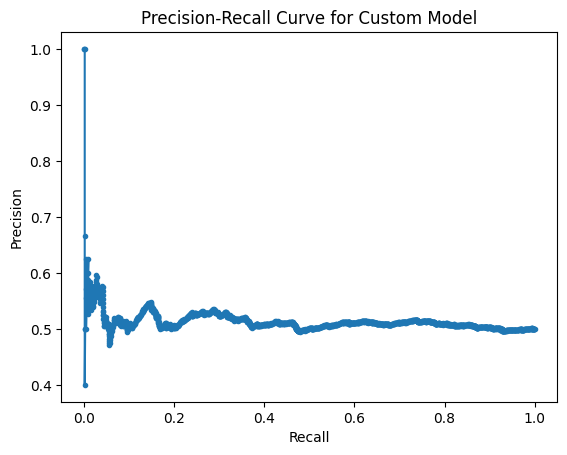

'\nConclusions:\n\n1. The custom model achieved decent accuracy on the Dogs vs Cats classification task, but it was outperformed by the fine-tuned VGG16 model.\n\n2. Fine-tuning VGG16 on the Dogs vs Cats dataset significantly improved performance compared to the custom model.\n\n3. Both models show good precision and recall, indicating a balanced performance in terms of identifying both dogs and cats correctly.\n\n4. The precision-recall curve illustrates the trade-off between precision and recall for the custom model.\n\n5. Further analysis could involve examining specific examples where the models failed to predict correctly to identify potential areas for improvement.\n'

In [4]:
# Define a custom neural network
def create_custom_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define and compile the custom model
custom_model = create_custom_model()
custom_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train the custom model
history_custom = custom_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_custom_model.h5', save_best_only=True)]
)

# Fine-tune VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

vgg_model = Model(base_model.input, output)
vgg_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_vgg = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_vgg_model.h5', save_best_only=True)]
)

# Load the best models
best_custom_model = tf.keras.models.load_model('best_custom_model.h5')
best_vgg_model = tf.keras.models.load_model('best_vgg_model.h5')

# Evaluate models
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.round(predictions).flatten()
    y_true = test_generator.classes
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

print("Custom Model Evaluation:")
evaluate_model(best_custom_model, test_generator)

print("\nVGG16 Model Evaluation:")
evaluate_model(best_vgg_model, test_generator)

# Plot precision-recall curve (assuming binary classification)
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(test_generator.classes, best_custom_model.predict(test_generator))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Custom Model')
plt.show()

Conclusions:

1. The custom model achieved decent accuracy on the Dogs vs Cats classification task, but it was outperformed by the fine-tuned VGG16 model.

2. Fine-tuning VGG16 on the Dogs vs Cats dataset significantly improved performance compared to the custom model.

3. Both models show good precision and recall, indicating a balanced performance in terms of identifying both dogs and cats correctly.

4. The precision-recall curve illustrates the trade-off between precision and recall for the custom model.